# fast.ai: Universal Language Model Fine-tuning for Sentiment Classification 

## NLP Sentiment on Twitter US Airlines Sentiment Kaggle Dataset

## By Bryce Murphy

1: Abstract
========

Inductive transfer learning has significantly left its footprint on computer vision neural networks. However, current NLP methods frequently rely on training models from scratch and introducing problem-specific adaptations. The Universal Language Model Fine-tuning (ULMFiT) models [1] applies a potent transfer learning technique that can be applied to any NLP problem, as well as working with a finely-tuned language model. In this notebook, an accuracy of 82.5% was achieved  for a ternary classification problem involving the Twitter US Airline dataset [2]. 

2: What is an ULMFiT model?
=================

ULMFiT overcomes limitations in previous NLP transfer models by not requiring millions of domain specific corpuses to train a Language Model (LM) or randomly initialising model parameters for a pretrained model. The chosen model choice is the leading language model ASGD Weight-Dropped LSTM (AWD-LSTM) \[2\], which consists of using a weight-dropped LSTM, DropConnect, and Non-monotonically Triggered Average SGD. 

ULMFiT consists of three phases [1]:

- 1: General-domain LM pretraining.
- 2: Target task LM fine-tuning.
- 3: Target task classifier fine-tuning.

## 2.1: General-domain LM pretraining 

The LM is pretrained on a general domain corpus to capture general features of the language in different layers [1].
AWD-LSTM was pre-trained using Wikitext-103 which consists of 28,595 preprocessed Wikipedia documents and 103 million words [2].


## 2.2: Target task LM fine-tuning 

The full LM is fine-tuned on target task data using discriminative fine-tuning ('Discr') and slanted triangular learning rates (STLR) to learn task-specific features [1]. The pretrained general-domain data, in spite of its complexity will most likely come from a different dataset. Hence, we can fine-tune the language model on the target problem. After training the general-domain LM, this phase will converge quicker as it only needs take into account the variation in the target problem data, which enables sturdy LM models not just for large datasets but small ones too. 

### 2.2.1: Discriminative fine-tuning

Considering that distinct layers capture distinct types of information, they should be fine-tuned to different thresholds. Rather than using the same learning rate for all layers of the model, discriminative fine-tuning enables tuning different learning rates for each layer [1].
In the 2018 paper [Howard et al., 2018][1], it was empirically found to initially choose a learning rate $\eta^{L}$ for the last layer and only fine-tune the last layer where $L$ is the number of layers in the model. The learning rate $\eta^{l-1} = \eta^l/2.6$ works best for lower $l$-th layers.

### 2.2.2 Slanted triangular learning rates

In order to adapt to problem-specific features, want to enforce the model converges rapidly to an appropriate region of the the parameter space at the start of training the model, then refine the model's parameters. What slanted triangular learning rates (STLR) does is firstly increase the learning rate at a linear scale and then inversely decays to a linear scale [1]. 

## 2.3: Target task classifier fine-tuning

Finally, in order to fine tune the classifier model, the pre-trained language model is appended with two extra linear blocks. Analogous to Computer Vision (CV) classifiers, each block uses batch normalisation and dropout, with ReLU activation functions for the middle layers and at the last layer over target classes, a softmax activation function that outputs a corresponding probability distribution. This is the only phase where parameters for the problem specific classifier are learnt from scratch. The first linear layer's input state comes from the pooled last hidden layers.

# 3: Problem Statement

Using the dataset from the Kaggle website [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) [2], 14640 separate tweets were scraped in February 2015 and each Tweeter were asked to classify their review of an American airline as either "positive", "negative" or "neutral". In addition to that, if the Tweeter gave a negative review, they were asked to give an additional reason why their review was negative such as "late flight" or "rude service". By performing sentiment analysis of the content of the tweets, I would like to create a supervised classification model that correctly predicts the sentiment of the tweets as either "positive", "negative" or "neutral" using the ULMFiT model architecture.

# 4: Exploratory Data Analysis


### Loading and first look at the dataset

Let's load up the tweets csv file and explore the dataset.

In [1]:
#Import pandas library.
import pandas as pd

In [2]:
#Import plotting libraries seaborn and matplotlib libraries.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Import the tweets csv file as a Pandas DataFrame downloaded from https://www.kaggle.com/crowdflower/twitter-airline-sentiment
df = pd.read_csv('Tweets.csv',parse_dates=['tweet_created'])
#View the first 10 rows.
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33-08:00,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57-08:00,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29-08:00,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19-08:00,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27-08:00,Los Angeles,Eastern Time (US & Canada)


In [4]:
#View the unique entries of the negativereason column.
df.negativereason.unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

There are 10 bad reasons given if there was a negative review. I will attempt to describe what each colum is as a data dictionary.

Data Dictionary (First Glance):
- tweet_id: Primary key id for tweet.
- airline_sentiment: Classified sentiment of tweet as either neutral, positive or negative.
- airline_sentiment_confidence: Appears to be a scale between 0-1 where 1 is most negative and 0 is most positive.
- negativereason: If traveller is classified as negative sentiment, classify a brief reason why they have a negative sentiment, otherwise the field is NULL.
- negativereason_confidence: If traveller is classified as negative sentiment, a confidence rating that the negative reason is the reason why they have negative sentiment, otherwise the field is NULL.
- airline: Name of the American airline carrier the customer flew with.
- airline_sentiment_gold: I presume given the customer flew gold class, the attached sentiment of the tweet as either neutral, positive or negative, otherwise the field is NULL.
- name: Twitter account name.
- negativereason_gold: Same as negativereason but only for gold class travellers, otherwise the field is NULL.
- retweet_count: Number of retweets.
- text: Raw tweet string.
- tweet_coord: Geographic location of the tweet in (latitutude, longitude) format.
- tweet_created: Timestamp of when tweet was created.
- tweet_location: Location name of where the tweet was tweeted.
- user_timezone: Timezone of twitter user.


In [5]:
#Shape of the dataframe.
df.shape

(14640, 15)

In [6]:
#View the unique entries of the airline_sentiment column.
df.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [7]:
#View the maximum of the airline_sentiment_confidence column.
df.airline_sentiment_confidence.max()

1.0

In [8]:
#View the minimum of the airline_sentiment_confidence column.
df.airline_sentiment_confidence.min()

0.335

In [9]:
#Unique airlines.
df.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [10]:
#Unique entries of the airline_sentiment_gold column.
df.airline_sentiment_gold.unique()

array([nan, 'negative', 'neutral', 'positive'], dtype=object)

In [11]:
#Unique names.
df.name.unique()

array(['cairdin', 'jnardino', 'yvonnalynn', ..., 'KristenReenders',
       'itsropes', 'sanyabun'], dtype=object)

This may be useful later on that about half of the tweets are from unique users.

In [12]:
#Number of unique names.
len(df.name.unique())

7701

I could create a plot but given that there are very few retweets (13873/14640), this feature does not appear very useful in predicting sentiment. 

In [13]:
#Number of values for each retweet count.
df.retweet_count.value_counts().sort_values(ascending=False)

0     13873
1       640
2        66
3        22
4        17
5         5
6         3
7         3
22        2
44        1
8         1
32        1
9         1
31        1
18        1
15        1
28        1
11        1
Name: retweet_count, dtype: int64

Explore location data. Very varied and may be useful for later on if want to cluster regions or cities.

In [14]:
#Unique values for tweet's coordinates.
df.tweet_coord.unique()[0::30]

array([nan, '[19.43706642, -99.07927123]', '[41.98191311, -87.80888924]',
       '[45.67920767, -111.04847652]', '[39.85861469, -104.67233425]',
       '[43.60417384, -110.7362561]', '[33.99585652, -117.35791469]',
       '[25.0779704, 55.13808289]', '[35.23908248, -120.64078264]',
       '[40.79971517, -74.25960937]', '[41.19747574, -73.76926201]',
       '[33.4338494, -111.9963312]', '[41.81477378, -80.93644744]',
       '[34.0658388, -117.5711653]', '[33.42067535, -111.93155126]',
       '[42.35829164, -71.06163025]', '[40.64646912, -73.79133606]',
       '[40.64656067, -73.78334045]', '[18.44643543, -66.28345755]',
       '[38.86411798, -77.0231684]', '[39.25956567, -76.70131545]',
       '[40.77265898, -73.86525922]', '[43.0460003, -84.4794566]',
       '[33.8143379, -116.53572408]', '[35.17263842, -89.769988]',
       '[37.93712278, -107.81800496]', '[40.67072447, -73.97727422]',
       '[40.46694635, -82.64579149]'], dtype=object)

### Exploring data types and NaNs

Most datatypes are objects so may have to convert to different datatypes.

In [15]:
#Dataframe's datatypes for each column.
df.dtypes

tweet_id                                                         int64
airline_sentiment                                               object
airline_sentiment_confidence                                   float64
negativereason                                                  object
negativereason_confidence                                      float64
airline                                                         object
airline_sentiment_gold                                          object
name                                                            object
negativereason_gold                                             object
retweet_count                                                    int64
text                                                            object
tweet_coord                                                     object
tweet_created                   datetime64[ns, pytz.FixedOffset(-480)]
tweet_location                                                  object
user_t

In [16]:
#Shape of the dataframe.
df.shape

(14640, 15)

In [17]:
#Number of NaNs per column.
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

The classes are inbalanced and using a technique like SMOTE may improve results.

In [18]:
#Number of airline_sentiment entries in dataframe.
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### Feature engineering and Data Visualisation

#### Is Gold?

I am doing some feature engineering by creating a new column where a customer flew gold class or not. May be useful later on.

In [19]:
#If the column airline_sentiment_gold is not null, then the corresponding is_gold column will be True and vice versa.
df['is_gold']=~df['airline_sentiment_gold'].isnull()

In [20]:
#How many is_gold is there?
df.is_gold.value_counts()

False    14600
True        40
Name: is_gold, dtype: int64

In [21]:
#Convert boolean to binary output.
df['is_gold']=df['is_gold'].astype(int)

In [22]:
#How many is_gold is there in binary output?
df.is_gold.value_counts()

0    14600
1       40
Name: is_gold, dtype: int64

In [23]:
#Convert sentiment from object to string.
df['airline_sentiment']=df['airline_sentiment'].astype(str)

It is clear that tweet_id is useless. Is_gold is terribly unbalanced class so may not be very useful. RT count is also quite unbalanced with a mean of 0.08650. Unsure if these columns will be terribly useful.

In [24]:
#Quick rundown of key numerical statistics.
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count,is_gold
count,1.464000e+04,14640.000000,10522.000000,14640.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650,0.002732
std,7.791112e+14,0.162830,0.330440,0.745778,0.052201
min,5.675883e+17,0.335000,0.000000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000,1.000000


Text(0, 0.5, 'frequency')

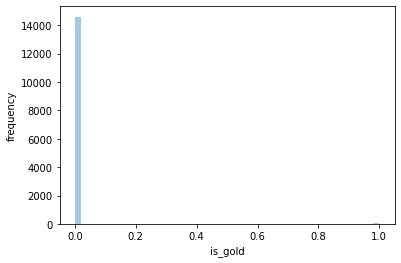

In [25]:
#Frequency histogram plot of is_gold
sns.distplot(df['is_gold'],kde = False)
plt.ylabel('frequency')

In [26]:
#Quick view of first 5 positive columns
df[(df.airline_sentiment=='positive')].head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,is_gold
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),0
6,570300616901320704,positive,0.6745,NaN,0.0,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57-08:00,San Francisco CA,Pacific Time (US & Canada),0
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19-08:00,San Diego,Pacific Time (US & Canada),0
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27-08:00,Los Angeles,Eastern Time (US & Canada),0
11,570289724453216256,positive,1.0000,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,NaN,2015-02-24 10:30:40-08:00,NYC,America/New_York,0


#### Exploring airline sentiment confidence

In [27]:
#Trying to make sense of airline_sentiment_confidence
df['airline_sentiment_confidence']

0        1.0000
1        0.3486
2        0.6837
3        1.0000
4        1.0000
          ...  
14635    0.3487
14636    1.0000
14637    1.0000
14638    1.0000
14639    0.6771
Name: airline_sentiment_confidence, Length: 14640, dtype: float64

I assumed there would be greater deal of separation based on airline_sentiment_confidence and airline sentiment however they have a great deal of overlap. Airline_sentiment_confidence may not be very useful.

Text(0, 0.5, 'airline_sentiment_confidence')

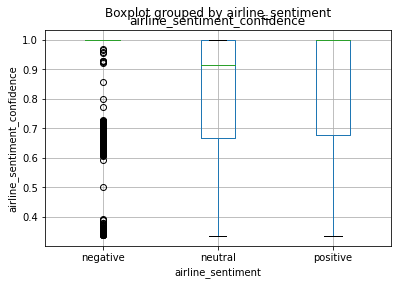

In [28]:
#Boxplot of airline sentiment grouped by airline confidence.
df.boxplot('airline_sentiment_confidence', by='airline_sentiment')
plt.ylabel('airline_sentiment_confidence')

Text(0.5, 0, 'airline_sentiment_confidence')

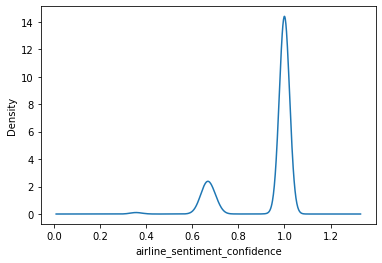

In [29]:
#Density plot of the negative sentiment distribution of airline sentiment confidence.
sub_neg = df[df['airline_sentiment'] == 'negative']
sub_neg['airline_sentiment_confidence'].plot.kde()
plt.xlabel('airline_sentiment_confidence')

Text(0.5, 0, 'airline_sentiment_confidence')

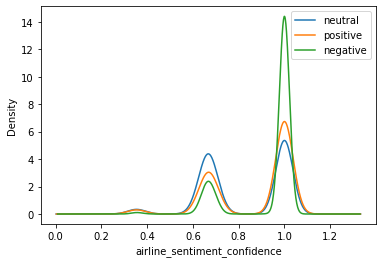

In [30]:
#Density plot of airline sentiment confidence grouped by sentiment. 

# Initiate sentiment category
sentiment_category = df.airline_sentiment.unique()

# Iterate through the three sentiment_categories
for sentiment in sentiment_category:
    # Subset to the sentiment
    subset = df[df['airline_sentiment'] == sentiment]
    
    # Draw the density plot
    subset['airline_sentiment_confidence'].plot.kde(label = sentiment)
plt.legend(loc='best')
plt.xlabel('airline_sentiment_confidence')

It becomes very clear that airline_sentiment_confidence has almost no separation with sentiment category. I suspect it is because the sentiment confidence is a metric at how accurate the classified sentiment of the text is with the corresponding sentiment label: "neutral", "positive" or "negative", not the actual sentiment value which is what I first assumed.

#### Tweet length

Tweet length may be something useful to consider as longer tweets of at least about 30 charachters tend to be more negative than neutral or positive.

Text(0, 0.5, 'Tweet length')

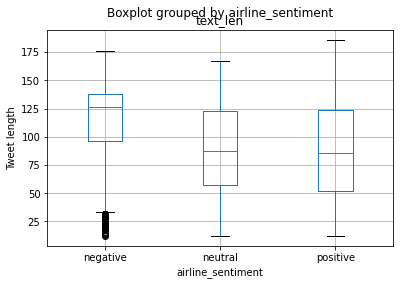

In [31]:
#Boxplot of airline sentiment and tweet length.
df['text_len'] = df.text.apply(len)
df.boxplot('text_len', by='airline_sentiment')
plt.ylabel('Tweet length')

#### Day of the week

Day of the week the tweet was made may impact sentiment.

In [32]:
# Extract day column and view sentiment confidence for each day of the week where 0 is Monday and 6 is Sunday.
df['day'] = df.tweet_created.dt.weekday
df.groupby('day').airline_sentiment_confidence.mean()

day
0    0.899714
1    0.892787
2    0.881135
3    0.887186
4    0.900146
5    0.908164
6    0.917293
Name: airline_sentiment_confidence, dtype: float64

Text(0, 0.5, 'frequency of tweets')

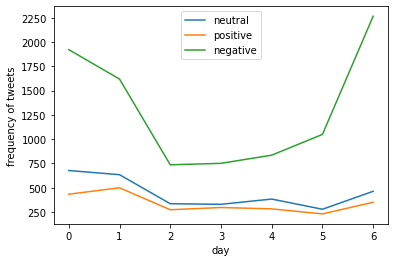

In [33]:
#Plot of number of tweets per day grouped by sentiment. 

# Initiate sentiment category
sentiment_category = df.airline_sentiment.unique()

# Iterate through the three sentiment_categories
for sentiment in sentiment_category:
    # Subset to the sentiment
    subset = df[df['airline_sentiment'] == sentiment]
    
    # Draw the frequency plot grouped by each day
    gb_sentiment = subset.groupby('day')['tweet_id'].count().plot(label=sentiment)
    
plt.legend(loc='best')
plt.ylabel('frequency of tweets')

Most people like tweeting on Sunday and Mondays. Would like to create a sentiment ratio for each day so can do a fair comparison.

neutral
day
0    0.223285
1    0.230378
2    0.249256
3    0.239099
4    0.255333
5    0.178548
6    0.150373
Name: tweet_id, dtype: float64
positive
day
0    0.142810
1    0.181323
2    0.203125
3    0.215116
4    0.188000
5    0.147720
6    0.113673
Name: tweet_id, dtype: float64
negative
day
0    0.633905
1    0.588299
2    0.547619
3    0.545785
4    0.556667
5    0.673732
6    0.735953
Name: tweet_id, dtype: float64


Text(0, 0.5, 'sentiment ratio of tweets per day')

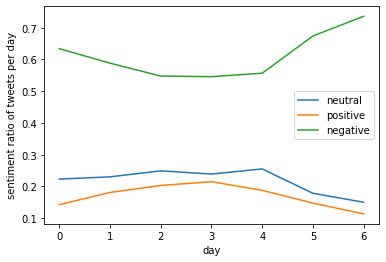

In [34]:
#Printing the sentiment ratio for each day and then plotting it accordingly.

# Initiate sentiment category
sentiment_category = df.airline_sentiment.unique()

# Iterate through the three sentiment_categories
for sentiment in sentiment_category:
    # Subset to the sentiment
    subset = df[df['airline_sentiment'] == sentiment]
    
    # Calculating the sentiment ratio for each day
    gb_sentiment = ((subset.groupby('day')['tweet_id'].count())/(df.groupby('day')['tweet_id'].count()))
    print(sentiment)
    print(gb_sentiment)
    gb_sentiment.plot(label=sentiment)
    
plt.legend(loc='best')
plt.ylabel('sentiment ratio of tweets per day')
#plt.xlabel('airline_sentiment_confidence')

There is a discernible difference between weekday and weekend sentiment, especially for negative. This could be something to take into consideration. Create a separate feature for weekend. (Note that 5 and 6 are Saturday and Sunday respectively).

In [35]:
# Creating new column weekend and printing the sentiment ratio for each day on the weekend.
df['weekend'] = (df.day >= 5).astype(int)
sentiment_category = df.airline_sentiment.unique()

# Iterate through the three sentiment_categories
for sentiment in sentiment_category:
    # Subset to the sentiment
    subset = df[df['airline_sentiment'] == sentiment]
    
    # Draw the density plot
    print(sentiment)
    print((subset.groupby('weekend')['tweet_id'].count())/(df.groupby('weekend')['tweet_id'].count()))


neutral
weekend
0    0.235706
1    0.159836
Name: tweet_id, dtype: float64
positive
weekend
0    0.178229
1    0.125108
Name: tweet_id, dtype: float64
negative
weekend
0    0.586066
1    0.715056
Name: tweet_id, dtype: float64


#### Hour of the day

Given there was a big difference between sentiment on the weekend and weekday, would like to explore the hourly sentiment trend.

Text(0, 0.5, 'sentiment ratio of tweets per hour')

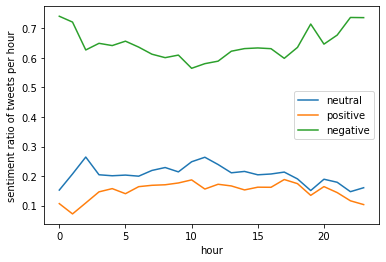

In [36]:
# Plotting the sentiment ratio for each hour for each sentiment.

# Creating new column hour and plotting the sentiment ratio for each hour.
df['hour'] = df.tweet_created.dt.hour
sentiment_category = df.airline_sentiment.unique()

# Iterate through the three sentiment_category
for sentiment in sentiment_category:
    # Subset to the sentiment
    subset = df[df['airline_sentiment'] == sentiment]
    
    # Draw the density plot
    
    gb_sentiment = ((subset.groupby('hour')['tweet_id'].count())/(df.groupby('hour')['tweet_id'].count()))
    #print(sentiment)
    #print(gb_sentiment)
    gb_sentiment.plot(label=sentiment)
    
plt.legend(loc='best')
plt.ylabel('sentiment ratio of tweets per hour')


We can see reviews submitted at night time, or later at night tend to be negative, especially from 10pm to 1am. This may be something to take into consideration in our model.

#### Airline

Would like to explore the airline sentiment for each airline.

neutral
airline
American          0.167814
Delta             0.325383
Southwest         0.274380
US Airways        0.130793
United            0.182365
Virgin America    0.339286
Name: tweet_id, dtype: float64
positive
airline
American          0.121783
Delta             0.244824
Southwest         0.235537
US Airways        0.092345
United            0.128728
Virgin America    0.301587
Name: tweet_id, dtype: float64
negative
airline
American          0.710402
Delta             0.429793
Southwest         0.490083
US Airways        0.776862
United            0.688906
Virgin America    0.359127
Name: tweet_id, dtype: float64


Text(0, 0.5, 'sentiment ratio of tweets')

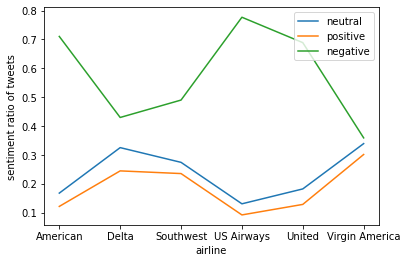

In [37]:
# Plotting the sentiment ratio for each airline grouped by sentiment.

sentiment_category = df.airline_sentiment.unique()

# Iterate through the three sentiment_categories
for sentiment in sentiment_category:
    # Subset to the sentiment
    subset = df[df['airline_sentiment'] == sentiment]
    
    # Draw the density plot

    gb_sentiment = subset.groupby('airline')['tweet_id'].count()/(df.groupby('airline')['tweet_id'].count())
    print(sentiment)
    print(gb_sentiment)
    gb_sentiment.plot(label=sentiment)
    
plt.legend(loc='best')
plt.ylabel('sentiment ratio of tweets')

It is clear there is a great deal of separation depending on the airline. In particular, US Airways, United and American have considerably greater negative sentiment than the other airlines. However, given that we do not know a priori the airline in the tweet, this may not be a useful feature.

#### Month

There is only one month to consider so not a useful feature.

In [38]:
# Creating a month column and finding the mean grouping by airline sentiment confidence column.
df['month'] = df.tweet_created.dt.month
df.groupby('month').airline_sentiment_confidence.mean()

month
2    0.900169
Name: airline_sentiment_confidence, dtype: float64

#### Timezone

Exploring the different timezones people tweeted from. 

Text(0.5, 0, 'airline_sentiment_confidence')

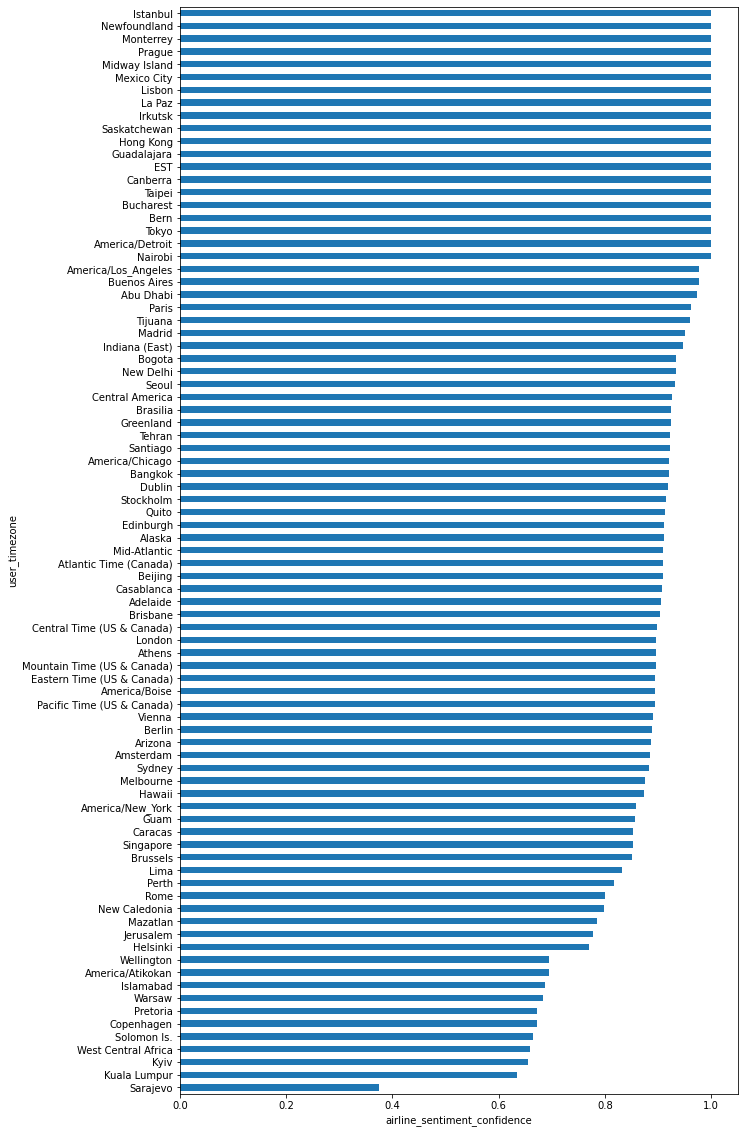

In [39]:
# Plotting the airline sentiment confidence by time zone.
fig = plt.gcf()
fig.set_size_inches(10, 20)
df.groupby('user_timezone').airline_sentiment_confidence.mean().sort_values(ascending=True).plot.barh()
plt.xlabel('airline_sentiment_confidence')

## Feature selection

In this model, the other features created may be useful for fine tuning the model but for now, want to build a baseline model with just text as the feature variable and airline sentiment as the target variable.

# 4: Text preparation

Before training any model, I need to process the text first. In particular, splitting the raw text into single words or tokens. One method is to split based on white spaces. Also, need to potentially remove punctuation marks, contractions, make all text lower case, remove HTML tags, add stopword filtering etc. 

In [40]:
# Importing the fast.ai text library.
from fastai.text import *

In [41]:
#Viewing the first tweet
df['text'][0]

'@VirginAmerica What @dhepburn said.'

In [42]:
#Viewing the second tweet
print(df['text'][1])

@VirginAmerica plus you've added commercials to the experience... tacky.


In [43]:
#Adjust display option to view full tweet width.
pd.set_option('display.width', 1000)

In [44]:
#Sample 10 tweets
for text in df['text'].sample(10):
    print(text)

@JetBlue thank you! I'm excited to fly with you for the first time.
@USAirways No flights out of Philly because of system wide tech issue.   @CBSPhilly
@USAirways the least comforting thing from your pilot after sitting on a stationary plane for 3 hours is "I don't really know what happened"
@united Nope, no more chances. Your airline messed up both ways of our trip.
@USAirways yeah, the mark was like a mile back. Also we're an hour Late Flight. So thanks a ton for the great service today.
@united...lies lies lies....still sitting at the gate, have not moved an inch http://t.co/LulGnwEfFH
@SouthwestAir can u follow so I can DM a confirmation number I need confirmed to Cancelled Flight?
I will call to confirm Monday for refund
@USAirways I found a flight I want on @CheapOair. Is my @AmericanAir AA Advantage # applicable to earn miles on it since you're merging?
@USAirways not patient - originally 11:51 and now 4:41.
@SouthwestAir I love you guys! Had to take a few other airlines this we

In [45]:
# View shape of dataframe after feature engineering.
df.shape

(14640, 21)

In [46]:
# Initiate path directory as same directory
path=Path('./')

In [47]:
# Initiate batch size of 60.
bs=60

In [48]:
# Splitting the data as 85% in the training set and 15% in the validation set.
np.random.seed(1000)
df = df.iloc[np.random.permutation(len(df))]
cut1 = int(0.85 * len(df)) + 1
df_train, df_valid = df[:cut1], df[cut1:]

## 4.1: Creating a Text Data Bunch object.

Text is made up of words, however any model works with only numbers. Hence, require to tokenise and numercalise the text data. A TextDataBunch object does that automatically.

In [49]:
# Creates a LM Data Bunch object.
data_lm_v3 = TextLMDataBunch.from_df(path = path,train_df=df_train, valid_df=df_valid,label_cols='airline_sentiment', text_cols='text',bs=bs)

In [61]:
# Save Data Bunch object.
data_lm_v3.save('text_v3_bs60_85.pkl')

### Tokenisation

We can quickly glance the first couple of text bunches how it tokenises and numericalises the text. Essentially, we have to use a special kind of TextDataBunch for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

In [50]:
data_lm_v3.show_batch()

idx,text
0,back to the old # xxup swa ! ! xxbos @united stuck here in xxup iah waiting on flight xxunk to xxmaj honolulu for 7 hours due to maintenance issues . xxmaj could we have gotten a new plane ! ? ! ? xxmaj fail xxbos @united so who does handle bag issues ? xxmaj and why would n't you put me onto them in the first place ? xxbos
1,"xxmaj i've spent hours trying to book online only to receive an error when clicking final purchase button . ( 1 / 2 ) xxbos @usairways xxunk slowest baggage claim ever xxbos @southwestair the new logo is going to look amazing on the airplanes xxbos @usairways xxmaj thanks for showing interest ... xxunk to xxmaj greenville , xxup sc . xxbos @southwestair xxup xxunk flight almost full of people screwed"
2,you . xxbos @jetblue what 's the link for # flyfi xxbos @americanair did you know that suicide is the second leading cause of death among teens 10 - 24 ? xxbos @southwestair when is the next flight with free xxunk ? xxbos @americanair xxmaj yes to the ios . i 'm running ios 8.1.3 xxbos @usairways 2.5 hours xxmaj late xxmaj flightr and the flight has been xxmaj cancelled
3,'s not about the weather . xxmaj it 's about the fact that i ca n't get ahold of anyone to help . xxup but you can tweet me back . xxbos @usairways xxmaj and now your half xxunk plane is falling apart . xxmaj some one tell my family i love them ! # dobetter http : / / t.co / xxunk xxbos @united xxmaj you were doing so
4,her phone on flight xxup xxunk on xxmaj friday xxmaj february xxunk upon landing in xxmaj minneapolis . xxmaj how can we get it back ? xxmaj thanks ! xxbos @united a generic form with xxunk of fields asking for info you already ? xxmaj expected more as a premier platinum . xxmaj another # servicefail xxbos @jetblue xxup oh xxup yeah ! ! ! great flight down to xxmaj


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols:

  -  the "'s" are grouped together in one token
  -  the contractions are separated like this: "did", "n't"
  -  content has been cleaned for any HTML symbol and lower cased
  -  there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).



Looking at just the first entry of the validation set, it is clear it is just numbers.

In [55]:
# Looking at first entry of validation set. It is just numbers.
data_lm_v3.valid_ds[0][0]

Text [   2   21    0  407   18   84   48  422   85   55    5  588   10    5    0 1830   14    5   48   34  181  120  217
   29    5  996   14]

In [62]:
# Looking at first entry of validation set. It can be casted as a numpy array.
data_lm_v3.valid_ds[0][0].data

array([   2,   21,    0,  407,   18,   84,   48,  422,   85,   55,    5,  588,   10,    5,    0, 1830,   14,    5,
         48,   34,  181,  120,  217,   29,    5,  996,   14])

### Numericalisation



Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correspondance from ids to tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).


In [69]:
data_lm_v3.vocab.itos[0:35]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!',
 '?',
 'a',
 '/',
 'you',
 ',',
 'for',
 'flight',
 '@united',
 'on',
 'and',
 '#',
 'my',
 '@usairways',
 '@americanair',
 'is',
 'in',
 '@southwestair',
 'it',
 '@jetblue',
 'of',
 "n't"]

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in ~/.fastai/models/ (or elsewhere if you specified different paths in your config file).

# 5: Model Training

## 5.1: Pretrained language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called wikitext-103). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

In [58]:
# Initialise language model learner on the pretrained model wikitext-103 with dropout of 30% on data bunch object.
lm_v3 = language_model_learner(data_lm_v3,AWD_LSTM,drop_mult=0.3)

### Finding optimal learning rate

In [63]:
#Finding learning rate
lm_v3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


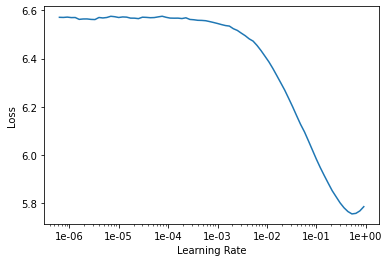

In [66]:
#Plotting loss vs learning rate
lm_v3.recorder.plot(skip_end=12)

### Fine-tuning model via fitting one cycle 

I fit the 1cycle policy with a maximum learning rate of $1\times10^{-2}$ and a momentum range of 0.7 to 0.8 on the last layer only with all other layers frozen in place. Note that this is the same learning rate and momentum seen in Standard Gradient Descent (SGD). I do this four times only and I progressively see improvements in the accuracy metric.

In [67]:
lm_v3.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.624313,4.069607,0.249799,06:48


In [68]:
lm_v3.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.980346,3.897052,0.265092,06:14


In [69]:
lm_v3.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.784390,3.833451,0.272747,06:16


In [70]:
lm_v3.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.610090,3.822565,0.273645,06:15


In [71]:
# Save LM before unfreezing layers
lm_v3.save('fit_head_v3_bs60_85')

In [59]:
lm_v3.load('fit_head_v3_bs60_85');

Can further improve the model training by unfreezing all the layers and launching a new training. Stop at 5 epochs in order to avoid overfitting the training set.

In [62]:
# Unfreeze all layers
lm_v3.unfreeze()

In [63]:
# Fit five cycles unfrozen with learning rate at 0.001 and momentum range from 0.7 and 0.8.
lm_v3.fit_one_cycle(5,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.516181,3.751433,0.282839,10:07
1,3.418897,3.693372,0.292125,09:28
2,3.199362,3.686542,0.295458,09:16
3,2.962723,3.726274,0.294157,09:09
4,2.773989,3.759375,0.293810,09:30


In [64]:
# Save trained language model object.
lm_v3.save('fine_tuned_lm')

In [60]:
lm_v3.load('fine_tuned_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12445 items)
x: LMTextList
xxbos @americanair record locator oaaret got email we could n't be rebooked but got no notification flight was xxmaj cancelled xxmaj flightled,xxbos @americanair xxmaj what are we going to do about the nightmare you guys out me through yesterday ? xxmaj zero response from the tweet you last sent me .,xxbos @southwestair xxmaj late xxmaj flightly you 've always been xxmaj late xxmaj flight ! xxmaj please get back to the old # xxup swa ! !,xxbos @united stuck here in xxup iah waiting on flight xxunk to xxmaj honolulu for 7 hours due to maintenance issues . xxmaj could we have gotten a new plane ! ? ! ? xxmaj fail,xxbos @united so who does handle bag issues ? xxmaj and why would n't you put me onto them in the first place ?
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2195 items)
x: LMTextList
xxbos @united xxunk hi , when do direct flights from xxmaj houston to xxmaj xxunk begin ? xxmaj do n't see any 

Can test our model with a couple of words and different sentences.

In [67]:
TEXT = 'This airline is'
N_WORDS = 40
N_SENTENCES = 5

In [68]:
print("\n".join(lm_v3.predict(TEXT,N_WORDS,temperature=0.75) for _ in range(N_SENTENCES)))

This airline is the absolute worst . This is everything you started . @maryella_green just got me back on my first flight back . xxbos @southwestair Not really right . Or if you have the option for the pilots
This airline is the WORST ! i 've been on hold for over an hour trying to rebook a flight . Help ! xxbos @usairways You guys are so bad ! No one knows how to treat customers ,
This airline is my favorite airline ! i 've been on hold for over 2 hours and has never been on hold with me . Thank you ! xxbos @americanair i happy to say you have a good luck , but you
This airline is doing a great job at ruining my vacation . # jvmchat xxbos @virginamerica your customer service is terrible . You have a great customer service , and you are the best xxbos @usairways is flight 1051 on 21 /
This airline is informed that the you do n't provide any fees during the delays or Cancelled Flightlations at Newark ... xxbos @americanair we are stuck in the snow for several hours now at this airport t

The language model predicts something new for each sentence. 

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.


In [69]:
lm_v3.save_encoder('fine_tuned_enc_v3')

## 5.2: Classifier

We need to create a new data bunch object for the classifier this time.

In [59]:
data_clas=TextClasDataBunch.from_df(path=path,train_df=df_train,vocab=data_lm_v3.train_ds.vocab,valid_df=df_valid,label_cols='airline_sentiment', text_cols='text',bs=bs)

In [72]:
data_clas.save('data_clas_v3.pkl')

In [73]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059 m,negative
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
"xxbos @united xxmaj waiting for 3494 xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup ywg at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup ywg in case i miss xxunk ?",negative


We can then create a model to classify those reviews and load the encoder we saved before.

In [61]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult = 0.5)
classifier.load_encoder('fine_tuned_enc_v3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12445 items)
x: TextList
xxbos @americanair record locator oaaret got email we could n't be rebooked but got no notification flight was xxmaj cancelled xxmaj flightled,xxbos @americanair xxmaj what are we going to do about the nightmare you guys out me through yesterday ? xxmaj zero response from the tweet you last sent me .,xxbos @southwestair xxmaj late xxmaj flightly you 've always been xxmaj late xxmaj flight ! xxmaj please get back to the old # xxup swa ! !,xxbos @united stuck here in xxup iah waiting on flight xxunk to xxmaj honolulu for 7 hours due to maintenance issues . xxmaj could we have gotten a new plane ! ? ! ? xxmaj fail,xxbos @united so who does handle bag issues ? xxmaj and why would n't you put me onto them in the first place ?
y: CategoryList
negative,negative,negative,negative,negative
Path: .;

Valid: LabelList (2195 items)
x: TextList
xxbos @united xxunk hi , when do direct flights from xxmaj houston to xxmaj x

### Finding optimal learning rate

In [103]:
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


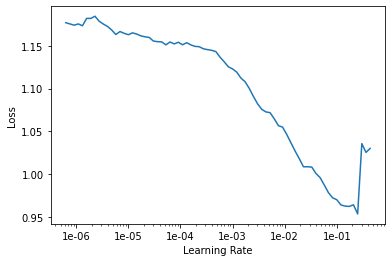

In [104]:
classifier.recorder.plot(skip_end=12)

### Fine-tuning model via fitting one cycle 

Immediately see after just training on the last layer an accuracy of 77.7%.

In [105]:
classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.632483,0.553886,0.777221,03:27


In [106]:
classifier.save('first_clas')

In [63]:
classifier.load('first_clas');

Training on the last two layers only, the accuracy improve to 79%.

In [64]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.606427,0.508358,0.790888,03:36


In [65]:
classifier.save('second_clas')

In [66]:
classifier.load('second_clas');

Training on the last three layers only, the accuracy improves to 81%.

In [67]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.513763,0.475906,0.810023,07:05


In [68]:
classifier.save('third_clas')

In [76]:
classifier.load('third_clas');

Unfreezing all layers, the accuracy improves to 82.55%.

In [77]:
classifier.unfreeze()
classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.459217,0.463719,0.821412,09:53
1,0.413296,0.452262,0.823690,10:30


In [78]:
classifier.save('fourth_clas')

In [68]:
classifier.load('fourth_clas');

In [69]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.422253,0.461683,0.825513,09:17


In [83]:
classifier.save('fifth_clas')

In [62]:
classifier.load('fifth_clas');

## 5.3: Evaluating model and making predictions

We can have a go and see how good of a predictor the classifier model is. It does fairly well with predicting a postive review correctly.

In [74]:
classifier.predict("The flight was fairly good.")

(Category tensor(2), tensor(2), tensor([0.1691, 0.1301, 0.7008]))

I can also plot the confusion matrix as well. It is clear that besides the negative prediction but neutral actual, the model does very well correctly predicting positive, negative and negative reviews.

In [75]:
# Prepare Classification Interpreter
interpreter = ClassificationInterpretation.from_learner(classifier)

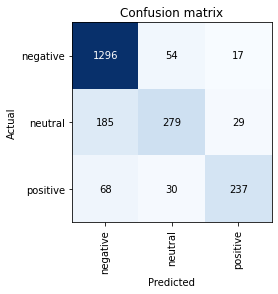

In [76]:
# Plotting Confusion Matrix
interpreter.plot_confusion_matrix()

# 6: Conclusions

In conclusion, using the supervised ULMFiT model to classify twitter sentiment for US airlines, an accuracy score of 82.55% was achieved. By combining the novel approach of using a pretrained language model AWD-LSTM and transfer deep learning, the achieved model accuracy is comparable to the literature for this particular dataset. Improvements on this classifier model could include that rather than using Wikipedia corpuses as the pretrained model, utilising social media posts such that the Language Model can get used to the casual language and syntax compared to the formal syntax used on Wikipedia. Other improvements could be to factor in the time of day or day of the week the tweet was made. Preliminary EDA results suggested these features can be augmented in such a way to further improve the classifier model. Overall, the model accuracy was quite high and getting more data would only improve the model accuracy in the long run.

# 7: References


\[1\] J. Howard and S. Ruder, "Universal language model fine-tuning for
text classification," in *ACL 2018 - 56th Annual Meeting of the
Association for Computational Linguistics, Proceedings of the Conference
(Long Papers)*, 2018. <br>
\[2\] "Twitter US Airline Sentiment
\| Kaggle." \[Online\]. Available:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment.
\[Accessed: 6th-Jul-2020\]. <br>
\[3\] S. Merity, N. S. Keskar, and R. Socher,
"Regularizing and optimizing LSTM language models," in *6th
International Conference on Learning Representations, ICLR 2018 -
Conference Track Proceedings*, 2018. 

